# Deep Learning for Human Vision Understanding 

## Basheer Alwaely and Ali Alsam

**Check tensorflow-GPU**

In [6]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Check Cuda version**

In [2]:
!nvidia-smi

Mon Feb  1 15:28:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   44C    P8     9W /  N/A |    265MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Import dependencies**

In [8]:
import keras
from keras.preprocessing import image
from keras.engine import Layer
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from PIL import Image, ImageFile
import cv2
config = tf.compat.v1.ConfigProto()                               # you might not need this
config.gpu_options.allow_growth = True                            # you might not need this
session = tf.compat.v1.InteractiveSession(config=config)          # you might not need this


**Paramters**

You need to download datasets or collect images in the folder

In [10]:
IMG_SIZE = 256                                                   # output image size
length_train = 4000                                              # number of training samples
length_test = 100                                                # number of testing samples

#path_train = '/content/drive/MyDrive/Colorizing/Train-data'      # train directory (modify)  
#path_test = '/content/drive/MyDrive/Colorizing/Test-data'        # test directory  (modify) 


datagen = ImageDataGenerator(rescale=1. / 255)
train = datagen.flow_from_directory(path_train, target_size=(IMG_SIZE, IMG_SIZE),batch_size=length_train,class_mode=None)
test = datagen.flow_from_directory(path_test, target_size=(IMG_SIZE, IMG_SIZE),batch_size=length_test,class_mode=None)

Found 800 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


**Blurred the blue channel**

You can change and select the target channel

In [12]:
Gamma = 21                                                      # Gaussian standard deviation 
## training samples
X =[]
Y =[]
for img in train[0]:
  try:
      r, g, b = cv2.split(img)
      bb = cv2.GaussianBlur(b,(3*Gamma,3*Gamma),Gamma)          # Gaussian kernel = 3 * Gamma
      blur = cv2.merge ( (r, g, bb) )                           # blurring
      X.append(blur)
      Y.append(b)
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

## testing samples
XX =[]
YY =[]
for img in test[0]:
  try:
      r, g, b = cv2.split(img)
      bb = cv2.GaussianBlur(b,(3*Gamma,3*Gamma),Gamma)
      blur = cv2.merge ( (r, g, bb) )
      XX.append(blur)
      YY.append(b)
  except:
     print('error')
XX = np.array(XX)
YY = np.array(YY)
print(XX.shape)
print(YY.shape)

(800, 256, 256, 3)
(800, 256, 256)
(100, 256, 256, 3)
(100, 256, 256)


**Define the model**

In [14]:
#Encoder
encoder_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3,))
encoder_output = Conv2D(6, (3,3), activation='relu', padding='same')(encoder_input)
encoder_output = Conv2D(12, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(8, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(4, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(2, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = Conv2D(1, (3, 3), activation='tanh', padding='same')(encoder_output)

model = Model(inputs=encoder_input, outputs=decoder_output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 6)       168       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 12)      660       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      1744      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 8)       1160      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 4)       292       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 2)       74    

**Train the model**

In [15]:
model.compile(optimizer='adam', loss='mse')
model.fit(X,Y, epochs=10, validation_data= (XX,YY) )

Epoch 1/10
25/25 [==============================] - 8s 128ms/step - loss: 0.1466 - val_loss: 0.0387
Epoch 2/10
25/25 [==============================] - 3s 117ms/step - loss: 0.0347 - val_loss: 0.0238
Epoch 3/10
25/25 [==============================] - 3s 114ms/step - loss: 0.0214 - val_loss: 0.0195
Epoch 4/10
25/25 [==============================] - 3s 113ms/step - loss: 0.0183 - val_loss: 0.0163
Epoch 5/10
25/25 [==============================] - 3s 114ms/step - loss: 0.0152 - val_loss: 0.0145
Epoch 6/10
25/25 [==============================] - 3s 115ms/step - loss: 0.0133 - val_loss: 0.0139
Epoch 7/10
25/25 [==============================] - 3s 114ms/step - loss: 0.0133 - val_loss: 0.0137
Epoch 8/10
25/25 [==============================] - 3s 113ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 9/10
25/25 [==============================] - 3s 115ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 10/10
25/25 [==============================] - 3s 111ms/step - loss: 0.0117 - val_loss: 0.0119

**Prediction**

In [16]:
output = np.reshape(model.predict(XX), (-1, IMG_SIZE, IMG_SIZE))

**Define statistical measurements**

In [18]:
def MSE(img,org):
    return np.square(np.subtract(img,org)).mean()

def PSNR(img,org):
    return tf.image.psnr(img, org, max_val=1)    # cv2.PSNR(img, org)

def SSIM(img,org):
    return tf.image.ssim(img, org, max_val=1.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

**Compute the MSE, PSNR and SSIM**

In [ ]:
mse  = []
psnr = []
ssim = []
for i in range(len(output)):
    img = output[i].reshape(IMG_SIZE,IMG_SIZE,-1)
    org = YY[i].reshape(IMG_SIZE,IMG_SIZE,-1)
    t1 = MSE(img,org)
    t2 = PSNR(img,org)
    t3 = SSIM(img,org)
    mse.append(t1)
    psnr.append(t2)
    ssim.append(t3)
    
mse = np.array(mse)
psnr = np.array(psnr)
ssim = np.array(ssim)
print(np.mean(mse))
print(np.mean(psnr))
print(np.mean(ssim))

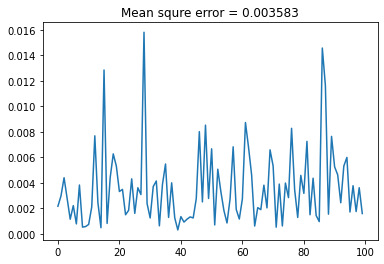

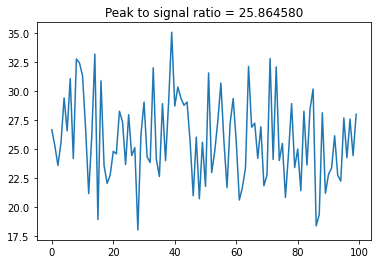

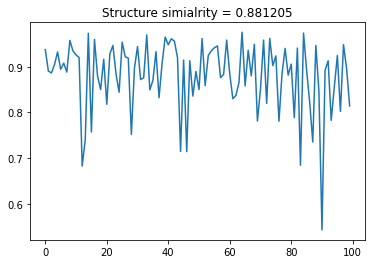

In [ ]:
t = np.mean(mse)
plt.title('Mean squre error = %f' %t)
plt.plot(mse)
plt.show()
t = np.mean(psnr)
plt.title('Peak to signal ratio = %f' %t)
plt.plot(psnr)
plt.show()
t = np.mean(ssim)
plt.title('Structure simialrity = %f' %t)
plt.plot(ssim)
plt.show()

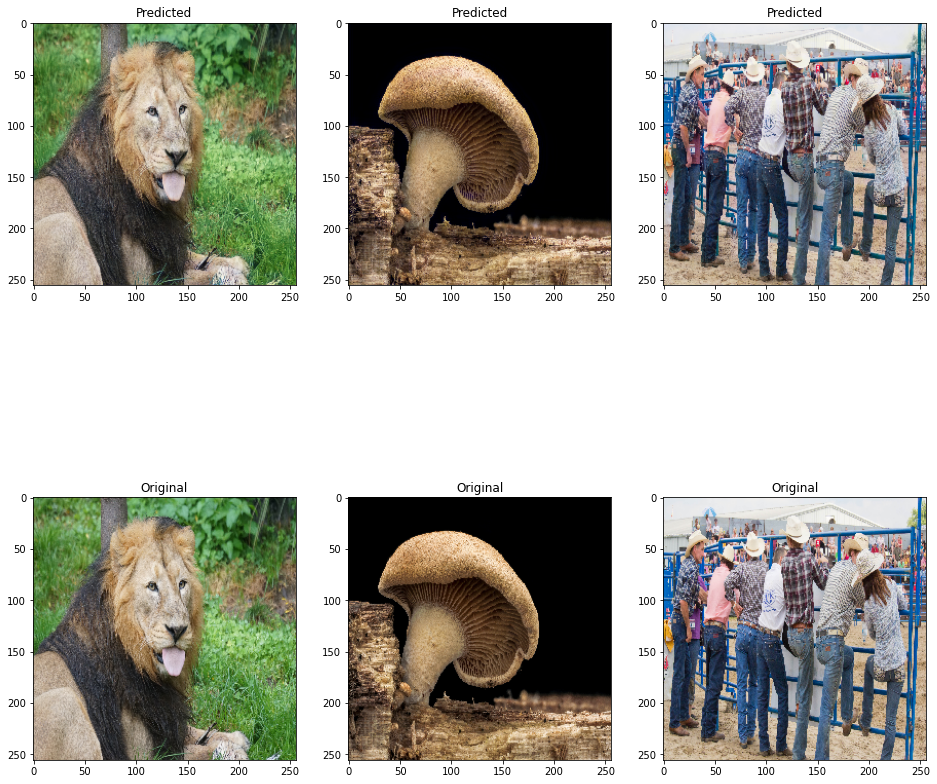

In [ ]:
m = 5    # index of the image in the dataset
k = 3    # how many imgaes to show after image(m)
s = 16   # size of the image to show
fig, axes = plt.subplots(nrows=2, ncols=k, sharex=True, sharey=True, figsize = (s,s))

for i in range(k): 
    result = np.zeros((IMG_SIZE, IMG_SIZE, 3))
    r, g, b = cv2.split(XX[i+m])
    result[:,:,0] = r
    result[:,:,1] = g
    result[:,:,2] = np.abs(output[i+m])
    plt.subplot(2, k, i+1)
    plt.imshow(result)
    plt.title('Predicted')
    
    org = np.zeros((IMG_SIZE, IMG_SIZE, 3))
    r, g, b = cv2.split(XX[i+m])
    org[:,:,0] = r
    org[:,:,1] = g
    org[:,:,2] = YY[i+m]
    plt.subplot(2, k, i+1+k)
    plt.imshow(org)
    plt.title('Original')
plt.show()

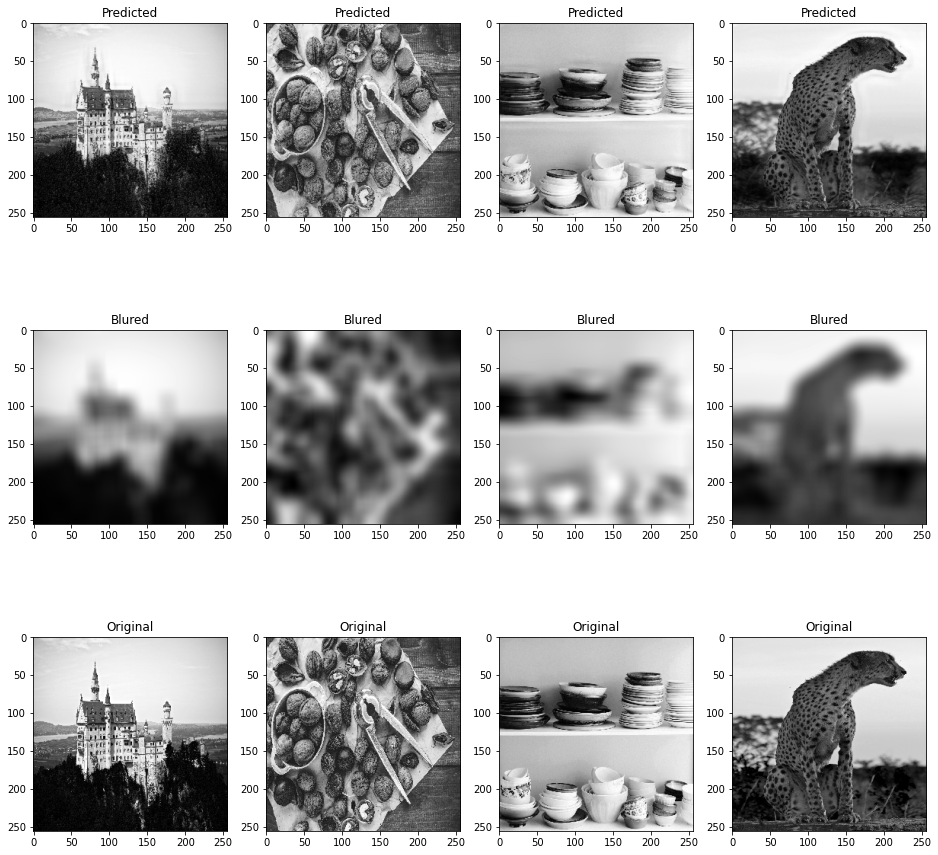

In [ ]:
m = 20    # index of the image in the dataset
k = 4    # how many imgaes to show after image(m)
s = 16   # size of the image to show
fig, axes = plt.subplots(nrows=3, ncols=k, sharex=True, sharey=True, figsize = (s,s))

for i in range(k): 
    result = np.abs(output[i+m]) 
    plt.subplot(3, k, i+1)
    plt.imshow(result)
    plt.title('Predicted')
    plt.gray()
    
    r, g, b = cv2.split(XX[i+m])
    plt.subplot(3, k, i+1+k)
    plt.imshow(b)
    plt.title('Blured')
    plt.gray()
    
    org = YY[i+m]
    plt.subplot(3, k, i+1+k+k)
    plt.imshow(org)
    plt.title('Original')
    plt.gray()


plt.show()

In [ ]:
#Encoder
encoder_input = Input(shape=(256, 256, 3,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(1, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)


#Encoder
encoder_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(1, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)